# Tensorflow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.get_logger().setLevel('ERROR')

Num GPUs Available:  1


## Preprocess images



In [2]:
# load data
train_data_dir = '../data/chest_Xray/train'
test_data_dir = '../data/chest_Xray/test'
val_data_dir = '../data/chest_Xray/val'

# Image size and batch size
img_height, img_width = 180, 180
batch_size = 32

# load and preprocess the dataset
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    seed=0,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.1,
    subset="both",
    color_mode="grayscale"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=0,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale"
)

Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Using 521 files for validation.
Found 624 files belonging to 2 classes.


In [4]:

class_names = train_ds.class_names
class_names


['NORMAL', 'PNEUMONIA']

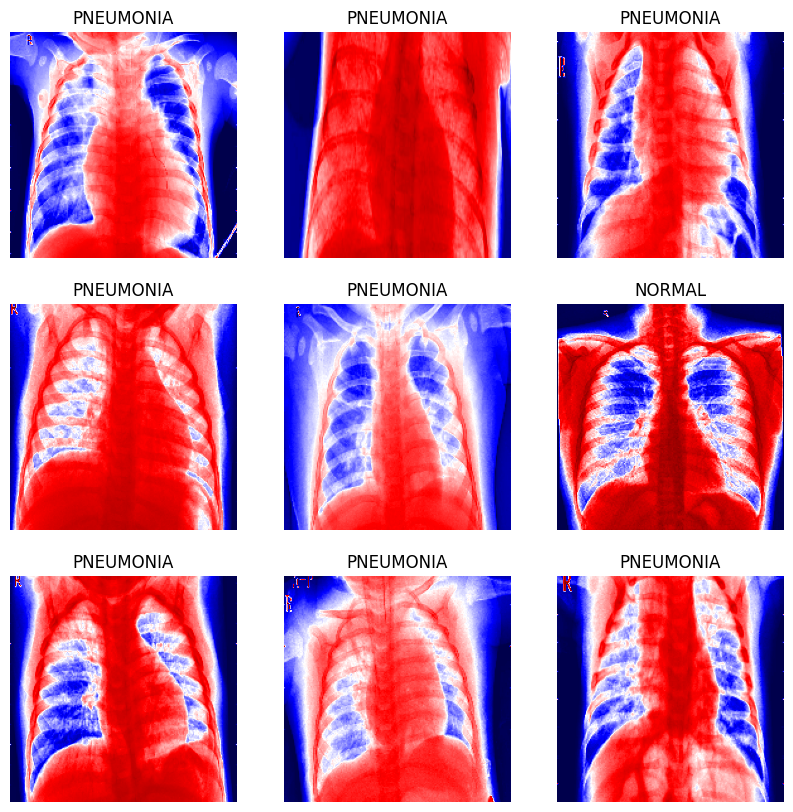

In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="seismic") # cmap works only with grayscale
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 1)
(32,)


# Model
## Multi-Layer Perceptron (MLP)

This kind of model is called a Multi-Layer Perceptron (MLP). While it can be used for image classification tasks, it is generally less effective than CNNs because it does not exploit the spatial structure and local patterns in images. Moreover, MLPs typically require more parameters and are more prone to overfitting compared to CNNs, especially when dealing with larger images.

### How to choose the end activation fonction?

For classification tasks, the two most common activation functions are softmax and sigmoid.

- `Softmax`: The softmax activation function is used for multi-class classification problems where each input can belong to one of multiple classes. It calculates the probabilities for each class, and the probabilities sum to 1. It is the recommended activation function for multi-class classification tasks.

- `Sigmoid`: The sigmoid activation function is typically used for binary classification problems, where each input can belong to one of two classes. The sigmoid function outputs a probability value between 0 and 1, representing the likelihood of an input belonging to the positive class. It is the recommended activation function for binary classification tasks.

Using the correct activation function for your specific problem will generally result in better model performance.



In [5]:
num_classes = len(train_ds.class_names) # 2 ["NORMAL", "PNEUMONIA"]

In [34]:
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
# view all the layers of the network
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 flatten_4 (Flatten)         (None, 32400)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               4147328   
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                                 
Total params: 4,147,586
Trainable params: 4,147,586
Non-trainable params: 0
_________________________________________________________________


In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
147/147 [==============================] - 6s 35ms/step - loss: 1.1162 - accuracy: 0.8552 - val_loss: 0.5164 - val_accuracy: 0.8772
Epoch 2/100
147/147 [==============================] - 5s 35ms/step - loss: 0.2717 - accuracy: 0.9261 - val_loss: 0.1995 - val_accuracy: 0.9405
Epoch 3/100
147/147 [==============================] - 5s 34ms/step - loss: 0.2789 - accuracy: 0.9276 - val_loss: 0.4979 - val_accuracy: 0.9002
Epoch 4/100
147/147 [==============================] - 5s 34ms/step - loss: 0.2310 - accuracy: 0.9408 - val_loss: 0.4466 - val_accuracy: 0.8925
Epoch 5/100
147/147 [==============================] - 5s 33ms/step - loss: 0.3882 - accuracy: 0.9174 - val_loss: 0.2095 - val_accuracy: 0.9539
Epoch 6/100
147/147 [==============================] - 5s 33ms/step - loss: 0.2881 - accuracy: 0.9316 - val_loss: 0.1220 - val_accuracy: 0.9635
Epoch 7/100
147/147 [==============================] - 5s 31ms/step - loss: 0.2790 - accuracy: 0.9355 - val_loss: 0.2122 - val_accuracy:

In [45]:
# visualize training results
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


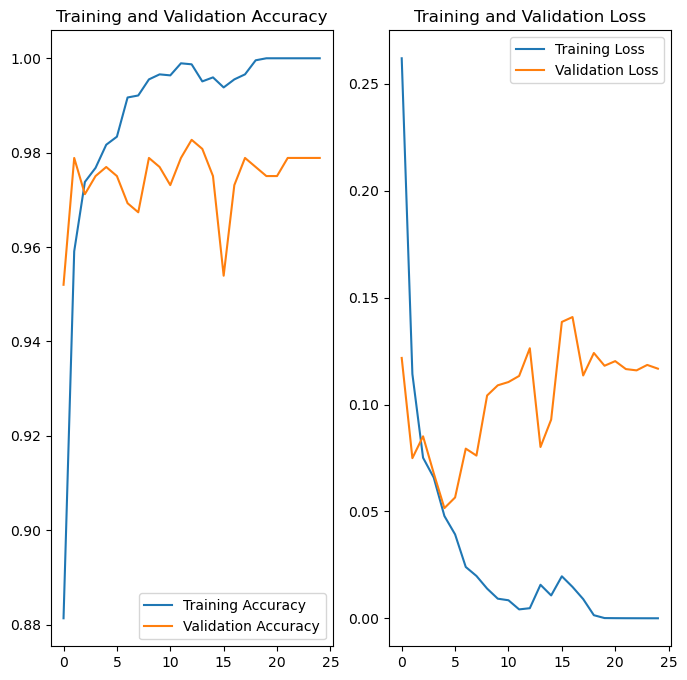

In [46]:
visualize(history)

In [47]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 42ms/step - loss: 0.8341 - accuracy: 0.7922
Test accuracy: 0.792187511920929


In [39]:
#save model
model.save("./tf_models/MLP", include_optimizer=False)

INFO:tensorflow:Assets written to: ./tf_models/MLP\assets


## CNN

![cnn](./images/a-cnn-sequence-to-classify-handwritten-digits.jpg)

1. `layers.Conv2D`: This is a convolutional layer that performs 2D convolution on the input data. The main utility of this layer is to detect local features or patterns (such as edges, corners, and textures) in the input image. The parameters of this layer are:
    - `16`: The number of filters (or kernels) to be used in the convolution operation. This determines the number of feature maps that the layer will output.

    - `(3, 3)`: The size of the filters (or kernels) used for the convolution. In this case, each filter is a 3x3 matrix. Smaller filter sizes are typically used to capture fine-grained features, while larger filter sizes capture more abstract or global features.

    - `activation='relu'`: The activation function applied to the output of the convolution operation. The Rectified Linear Unit (ReLU) activation function is commonly used in CNNs due to its ability to introduce non-linearity, speed up training, and mitigate the vanishing gradient problem.

2. `layers.MaxPooling2D`: This is a pooling layer that performs 2D max pooling on the input data. The main utility of this layer is to reduce the spatial dimensions (height and width) of the input feature maps, which helps to:

    - Reduce the number of parameters in the network, making it computationally more efficient and less prone to overfitting.

    - Enhance the network's ability to capture more abstract features, as the pooling operation aggregates information from adjacent pixels.

    - Improve the network's translation invariance, as the pooling operation makes the network less sensitive to small translations in the input image.

In summary, the combination of the `Conv2D` layer and the `MaxPooling2D` layer allows the CNN to learn and extract hierarchical features from the input image while reducing the overall complexity of the network.


In [13]:
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),

    layers.Conv2D(16, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 64)       

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
147/147 [==============================] - 15s 60ms/step - loss: 0.2372 - accuracy: 0.9012 - val_loss: 0.1470 - val_accuracy: 0.9463
Epoch 2/100
147/147 [==============================] - 5s 31ms/step - loss: 0.1104 - accuracy: 0.9591 - val_loss: 0.0911 - val_accuracy: 0.9655
Epoch 3/100
147/147 [==============================] - 4s 28ms/step - loss: 0.0878 - accuracy: 0.9670 - val_loss: 0.0557 - val_accuracy: 0.9866
Epoch 4/100
147/147 [==============================] - 4s 29ms/step - loss: 0.0768 - accuracy: 0.9734 - val_loss: 0.0662 - val_accuracy: 0.9827
Epoch 5/100
147/147 [==============================] - 4s 28ms/step - loss: 0.0496 - accuracy: 0.9808 - val_loss: 0.0530 - val_accuracy: 0.9846
Epoch 6/100
147/147 [==============================] - 4s 28ms/step - loss: 0.0451 - accuracy: 0.9832 - val_loss: 0.0937 - val_accuracy: 0.9693
Epoch 7/100
147/147 [==============================] - 4s 29ms/step - loss: 0.0374 - accuracy: 0.9845 - val_loss: 0.0795 - val_accuracy

KeyboardInterrupt: 

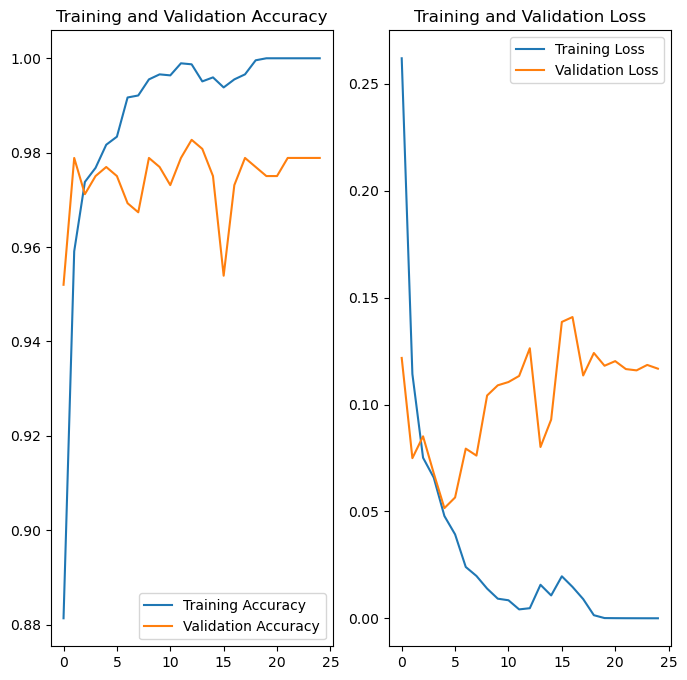

In [48]:
visualize(history)

In [49]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 8s 413ms/step - loss: 0.8341 - accuracy: 0.7922
Test accuracy: 0.792187511920929


In [50]:
#save model
model.save("./tf_models/CNN", include_optimizer=False)

INFO:tensorflow:Assets written to: ./tf_models/CNN\assets


INFO:tensorflow:Assets written to: ./tf_models/CNN\assets


## Optimisation: Data augmentation

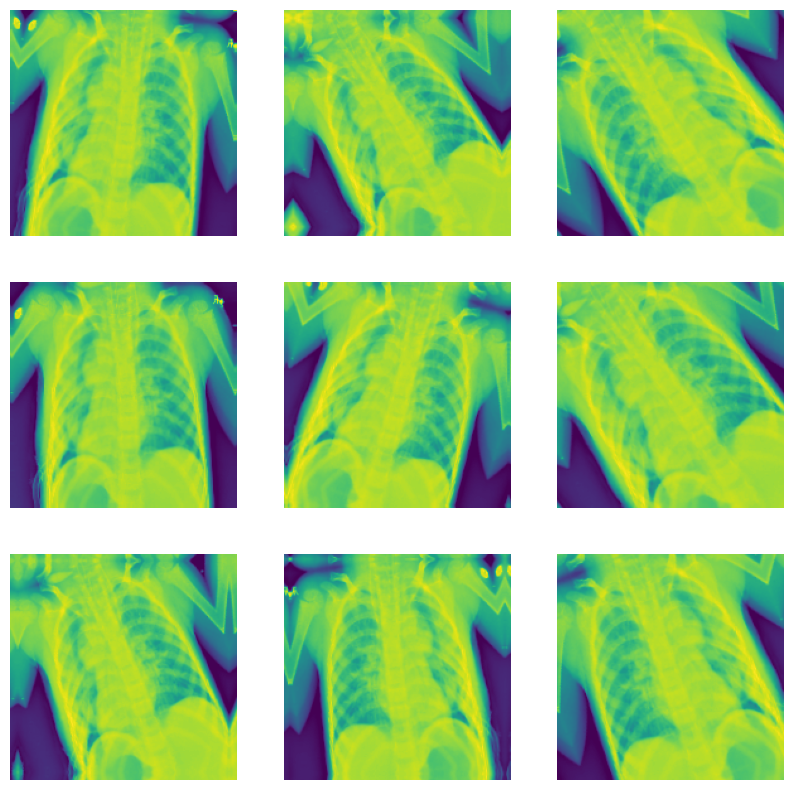

In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# visualize
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [17]:
from keras import Input

model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 1)),
    data_augmentation,
    layers.Rescaling(1./255),
    
    layers.Conv2D(16, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 1)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 16)      160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                 

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
147/147 [==============================] - 26s 173ms/step - loss: 0.3556 - accuracy: 0.8443 - val_loss: 0.5714 - val_accuracy: 0.7831
Epoch 2/100
147/147 [==============================] - 26s 176ms/step - loss: 0.2495 - accuracy: 0.9001 - val_loss: 0.2716 - val_accuracy: 0.8829
Epoch 3/100
147/147 [==============================] - 27s 182ms/step - loss: 0.2012 - accuracy: 0.9165 - val_loss: 0.2813 - val_accuracy: 0.8829
Epoch 4/100
147/147 [==============================] - 27s 182ms/step - loss: 0.1700 - accuracy: 0.9327 - val_loss: 0.2620 - val_accuracy: 0.8983
Epoch 5/100
147/147 [==============================] - 27s 181ms/step - loss: 0.1576 - accuracy: 0.9372 - val_loss: 0.3782 - val_accuracy: 0.8868
Epoch 6/100
147/147 [==============================] - 28s 191ms/step - loss: 0.1358 - accuracy: 0.9476 - val_loss: 0.2314 - val_accuracy: 0.9136
Epoch 7/100
147/147 [==============================] - 28s 186ms/step - loss: 0.1453 - accuracy: 0.9453 - val_loss: 0.2619 -

In [20]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 36ms/step - loss: 0.8990 - accuracy: 0.8125
Test accuracy: 0.8125


In [21]:
model.save("./tf_models/CNN_AUGMENTATION_DROPOUT", include_optimizer=False)

### test with bigger conv2d filter 

In [9]:
from keras import Input

model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 1)),
    data_augmentation,
    layers.Rescaling(1./255),
    
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


# prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
147/147 [==============================] - 30s 187ms/step - loss: 0.3915 - accuracy: 0.8247 - val_loss: 0.8559 - val_accuracy: 0.7543
Epoch 2/100
147/147 [==============================] - 29s 193ms/step - loss: 0.2293 - accuracy: 0.9044 - val_loss: 0.3783 - val_accuracy: 0.8503
Epoch 3/100
147/147 [==============================] - 30s 202ms/step - loss: 0.1984 - accuracy: 0.9199 - val_loss: 0.2128 - val_accuracy: 0.9175
Epoch 4/100
147/147 [==============================] - 30s 201ms/step - loss: 0.1564 - accuracy: 0.9372 - val_loss: 0.8780 - val_accuracy: 0.7812
Epoch 5/100
147/147 [==============================] - 31s 206ms/step - loss: 0.1448 - accuracy: 0.9427 - val_loss: 0.2284 - val_accuracy: 0.9079
Epoch 6/100
147/147 [==============================] - 28s 191ms/step - loss: 0.1358 - accuracy: 0.9474 - val_loss: 0.2596 - val_accuracy: 0.8983
Epoch 7/100
147/147 [==============================] - 28s 192ms/step - loss: 0.1356 - accuracy: 0.9491 - val_loss: 0.3014 -

In [10]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 16ms/step - loss: 0.5407 - accuracy: 0.8562
Test accuracy: 0.856249988079071


In [11]:
model.save("./tf_models/85%", include_optimizer=False)

In [15]:
from keras import Input

model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 1)),
    data_augmentation, # prevent overfitting
    layers.Rescaling(1./255),
    
    layers.Conv2D(32, (3, 3)),
    layers.BatchNormalization(), # help improve the training speed and model performance by reducing the internal covariate shift.
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(), # help reduce the number of parameters in the model and make it less prone to overfitting.
    layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


# prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many consecutive epochs don't improve to wait before stopping
    restore_best_weights=True, # delete if overfitting ( usually the lowest validation loss or highest validation accuracy)
    verbose=1,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
147/147 [==============================] - 32s 200ms/step - loss: 0.4225 - accuracy: 0.8550 - val_loss: 1.4472 - val_accuracy: 0.7236
Epoch 2/100
147/147 [==============================] - 32s 216ms/step - loss: 0.3437 - accuracy: 0.8854 - val_loss: 2.3839 - val_accuracy: 0.7236
Epoch 3/100
147/147 [==============================] - 34s 227ms/step - loss: 0.3175 - accuracy: 0.8967 - val_loss: 1.3052 - val_accuracy: 0.7236
Epoch 4/100
147/147 [==============================] - 31s 207ms/step - loss: 0.2958 - accuracy: 0.8986 - val_loss: 1.1086 - val_accuracy: 0.7294
Epoch 5/100
147/147 [==============================] - 31s 208ms/step - loss: 0.2842 - accuracy: 0.8963 - val_loss: 0.8800 - val_accuracy: 0.5643
Epoch 6/100
147/147 [==============================] - 31s 208ms/step - loss: 0.2779 - accuracy: 0.9048 - val_loss: 0.5074 - val_accuracy: 0.7601
Epoch 7/100
147/147 [==============================] - 31s 208ms/step - loss: 0.2607 - accuracy: 0.9091 - val_loss: 0.3347 -

In [16]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 23ms/step - loss: 1.0559 - accuracy: 0.5813
Test accuracy: 0.581250011920929


## try to find the best model

In [17]:
from keras import Input

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 1)),
    data_augmentation,
    layers.Rescaling(1./255),
    
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


# prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
147/147 [==============================] - 32s 201ms/step - loss: 0.5321 - accuracy: 0.7448 - val_loss: 0.4195 - val_accuracy: 0.7236
Epoch 2/100
147/147 [==============================] - 30s 200ms/step - loss: 0.3651 - accuracy: 0.8300 - val_loss: 0.3582 - val_accuracy: 0.9251
Epoch 3/100
147/147 [==============================] - 30s 200ms/step - loss: 0.3481 - accuracy: 0.8605 - val_loss: 0.3026 - val_accuracy: 0.9136
Epoch 4/100
147/147 [==============================] - 29s 195ms/step - loss: 0.3210 - accuracy: 0.8677 - val_loss: 0.2926 - val_accuracy: 0.8925
Epoch 5/100
147/147 [==============================] - 29s 196ms/step - loss: 0.2622 - accuracy: 0.8912 - val_loss: 0.2726 - val_accuracy: 0.8944
Epoch 6/100
147/147 [==============================] - 29s 193ms/step - loss: 0.2526 - accuracy: 0.8984 - val_loss: 0.1756 - val_accuracy: 0.9367
Epoch 7/100
147/147 [==============================] - 29s 193ms/step - loss: 0.2195 - accuracy: 0.9131 - val_loss: 0.1501 -

In [18]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 32ms/step - loss: 0.6645 - accuracy: 0.8250
Test accuracy: 0.824999988079071
